# **Fine-Tune Wav2Vec2 XLS-R for Luganda ASR with 🤗 Transformers**

Adapted from [Fine-tuning XLS-R for Multi-Lingual ASR with 🤗 Transformers](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2) and [
Boosting Wav2Vec2 with n-grams in 🤗 Transformers](https://huggingface.co/blog/wav2vec2-with-ngram)

In [ ]:
# Check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)

#### Install Packages
We shall install `datasets`, `transformers`, `accelerate` for model training. `torchaudio` to load audio files and `jiwer` to evaluate the model using word error rate (WER) and character error rate(CER)

In [8]:
%%capture
!pip install datasets==3.2.0
!pip install transformers==4.48.3
!pip install torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install jiwer # jiwer is used for evaluation using WER and CER
!pip install accelerate -U # Restart runtime after running this cell
!pip install wandb
!pip install librosa
!pip install soundfile
!pip install evaluate
!pip install matplotlib
!pip install seaborn
!pip install pyctcdecode

#### IMPORT

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#### Huggingface login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Install Git-LFS to support uploading model weights to huggingface

In [4]:
%%capture
!apt install git-lfs

### Prepare Data, Tokenizer, Feature Extractor
XLS-R uses the Wav2Vec2CTCTokenizer and the Wav2Vec2FeatureExtractor to process the inputs of the model

#### Download the dataset

In [5]:
from datasets import load_dataset, Audio

In [ ]:
# You need to log in on HuggingFace and accept the terms and conditions of the Mozilla Foundation common voice dataset
lg_cv_train = load_dataset("mozilla-foundation/common_voice_7_0", "lg", split="train+validation", trust_remote_code=True)
lg_cv_test = load_dataset("mozilla-foundation/common_voice_7_0", "lg", split="test", trust_remote_code=True)

In [ ]:
# Print the dataset to view a summary of the dataset
print(lg_cv_train)
print(lg_cv_test)

In [ ]:
# Select a sample from the dataset and view its audio colummn
lg_cv_train[0]['audio']

In [94]:
lg_cv_train = lg_cv_train.select_columns(['audio', 'Transcriptions', 'duration'])
lg_cv_test  = lg_cv_test.select_columns(['audio', 'Transcriptions', 'duration'])

In [ ]:
# Use this code to compute number of samples required to make up a total duration of interest
cumsum_length = np.cumsum(lg_cv_train['duration'])
cumsum_length[cumsum_length < 18_000].shape

In [ ]:
sum(lg_cv_train['duration'])/3600

### Display

In [97]:
# Show samples from the dataset
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML


def show_random_elements(dataset, num_examples= 10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = (random.randint(0, len(dataset)-1))
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(lg_cv_train.remove_columns(['audio']))

In [99]:
# normalize the transcripts. We are not training an orthographic model
def normalize(batch):
    batch['transcription'] = batch['Transcriptions'].lower()
    return batch

lg_cv_train = lg_cv_train.map(normalize)
lg_cv_test = lg_cv_test.map(normalize)

In [22]:
# Obtain the vocabulary from the dataset
def extract_all_chars(batch):
  all_text = " ".join(batch["transcription"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
luganda_train_vocab   = lg_cv_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=lg_cv_train.column_names)
luganda_test_vocab   = lg_cv_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=lg_cv_test.column_names)

In [24]:
vocab_list = list(set(luganda_train_vocab["vocab"][0]) | set(luganda_test_vocab["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

#### Build Tokenizer and Feature Extactor

In [26]:
# Replace the spaces with |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [27]:
# Add a padding token that corresponds to CTC blank token
vocab_dict['[UNK]'] = len(vocab_dict)
vocab_dict['[PAD]'] = len(vocab_dict)
len(vocab_dict)

34

In [28]:
# save the vocabulary as a json file
import json
with open('luganda-xls-r.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [29]:
# Load the vocabulary into an instance of the Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("username/repo", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [ ]:
tokenizer.push_to_hub("username/repo")

#### Create Wav2Vec2FeatureExtractor

In [31]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [32]:
# Wrap the feature extractor and tokenizer in the Wav2Vec2Processor
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
processor.push_to_hub('username/repo')

In [ ]:
# Play an audio sample from the dataset
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(lg_cv_train)-1)
print(lg_cv_train[rand_int]["transcription"])
ipd.Audio(data=np.asarray(lg_cv_train[rand_int]["audio"]["array"]), autoplay=False, rate=16000)

In [ ]:
lg_cv_train[rand_int]["audio"]["sampling_rate"]

In [36]:
# Plot a graph of the audio
import matplotlib.pyplot as plt
from itertools import cycle

In [37]:
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [38]:
y = lg_cv_train[rand_int]["audio"]["array"]

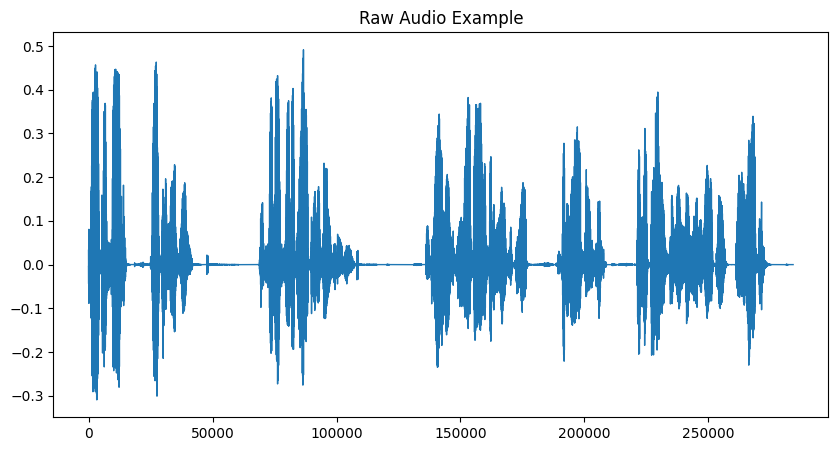

In [39]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

In [40]:
# Prepare the data for training
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch['length'] = batch["duration"]

    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids
    return batch

In [41]:
# wolof_kallaama_train = wolof_kallaama_train.cast_column('audio', Audio(16000))
lg_cv_train = lg_cv_train.cast_column('audio', Audio(16000))
lg_cv_test = lg_cv_test.cast_column('audio', Audio(16000))

In [ ]:
# Apply the data preparation function to the data
lg_cv_train = lg_cv_train.map(prepare_dataset, num_proc=8, remove_columns=lg_cv_train.column_names)
lg_cv_test  = lg_cv_test.map(prepare_dataset, num_proc=8, remove_columns=lg_cv_test.column_names)

In [ ]:
sum(lg_cv_train['length'])/3600

In [ ]:
print(lg_cv_train)

### Training

Create a special collate function that pads the input values to the maximum length in the batch because XLS-R has a very long context length

#### Set-up Trainer

In [45]:
# Apply separate padding to the input and the labels
# Set the padding value to -100 so that the tokens are not taken into account in the loss function

import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split  inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature['input_values']} for feature in features]
        label_features = [{"input_ids": feature['labels']} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding = self.padding,
            return_tensors = "pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding = self.padding,
                return_tensors = "pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch['input_ids'].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [46]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [47]:
# Define the wer and cer metrics
import evaluate

wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [48]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

In [ ]:
# Load the Wav2Vec2-XLS-R-300M
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.1,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

In [50]:
model.config.ctc_zero_infinity = True

In [51]:
# Freeze the feature extractor as it has been sufficiently trained
model.freeze_feature_extractor()

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
model = model.to(device)

#### Baseline Test

In [74]:
input_dict = lg_cv_test[0]

logits = model(torch.tensor(input_dict["input_values"]).to("cuda").unsqueeze(0)).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

In [ ]:
processor.decode(pred_ids)

In [ ]:
processor.decode(input_dict["labels"]).lower()

In [ ]:
# Evaluation is carried out with a batch size of 1
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

results = lg_cv_test.map(map_to_result, remove_columns=lg_cv_test.column_names)

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

In [ ]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

#### Wandb for Logging and Montoring

In [ ]:
import wandb

wandb.login()

In [ ]:
# Wandb arguments
%env WANDB_LOG_MODEL=end
%env WANDB_PROJECT=ASR Africa
%env WANDB_WATCH=all
%env WANDB_SILENT=true

In [56]:
# Define the training arguments
# use the group_by_length argument to make training more efficient

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./rep0",
    group_by_length=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2, # increase the effective batch size to 4,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    save_strategy ="steps",
    num_train_epochs=50,
    bf16=True, # mixed precision training
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    learning_rate=3e-4,
    warmup_ratio=0.1,
    save_total_limit=2,
    push_to_hub=True,
    gradient_checkpointing=True,
    report_to="wandb",
    run_name="repo",
    load_best_model_at_end=True,
    hub_private_repo = True,
    torch_compile = True,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,
    metric_for_best_model = "wer",  
    greater_is_better=False,
    hub_model_id='asr-africa/repo',
    )

In [57]:
# Pass the model, the training arguments and the data collator to the Trainer

from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=lg_cv_train,
    eval_dataset=lg_cv_test,
    tokenizer=processor.feature_extractor,
)

In [58]:
import numpy as np

In [ ]:
trainer.train()
wandb.finish()
trainer.push_to_hub('username/repo')

### Test Model

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    'username/repo',
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

In [62]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [63]:
model = model.to(device)

In [64]:
input_dict = lg_cv_test[0]

logits = model(torch.tensor(input_dict["input_values"]).to("cuda").unsqueeze(0)).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

In [ ]:
processor.decode(pred_ids)

In [ ]:
processor.decode(input_dict["labels"]).lower()

In [ ]:
# Evaluation is carried out with a batch size of 1
def map_to_result(batch):
    model.eval()
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits
    
    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
    batch['duration'] = batch['length']
    
    return batch

results = lg_cv_test.map(map_to_result, remove_columns=lg_cv_test.column_names)

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

In [ ]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

In [71]:
def calculate_wer_cer(batch):
    batch['WER'] = wer_metric.compute(references=[batch['text']], predictions=[batch['pred_str']])
    batch['CER'] = cer_metric.compute(references=[batch['text']], predictions=[batch['pred_str']])
    return batch

In [ ]:
results = results.map(calculate_wer_cer, num_proc=8)

In [ ]:
show_random_elements(results)

In [74]:
results_df = results.to_pandas()

In [75]:
results_df.to_csv('predictions/results', index =False)

## Build an n-gram language model

In [98]:
with open("text.txt", "w") as file:
  file.write(" ".join(lg_cv_train["Transcriptions"]))

In [101]:
with open("5gram.arpa", "r") as read_file, open("5gram_correct.arpa", "w") as write_file:
  has_added_eos = False
  for line in read_file:
    if not has_added_eos and "ngram 1=" in line:
      count=line.strip().split("=")[-1]
      write_file.write(line.replace(f"{count}", f"{int(count)+1}"))
    elif not has_added_eos and "<s>" in line:
      write_file.write(line)
      write_file.write(line.replace("<s>", "</s>"))
      has_added_eos = True
    else:
      write_file.write(line)

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained('username/repo')

In [77]:
vocab_dict = processor.tokenizer.get_vocab()
sorted_vocab_dict = {k.lower(): v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1])}

In [ ]:
from pyctcdecode import build_ctcdecoder

decoder = build_ctcdecoder(
    labels=list(sorted_vocab_dict.keys()),
    kenlm_model_path="5gram_correct.arpa",
)

In [79]:
from transformers import Wav2Vec2ProcessorWithLM

processor_with_lm = Wav2Vec2ProcessorWithLM(
    feature_extractor=processor.feature_extractor,
    tokenizer=processor.tokenizer,
    decoder=decoder
)

In [ ]:
from huggingface_hub import Repository

repo = Repository(local_dir="username/repo", clone_from="username/repo")

In [81]:
processor_with_lm.save_pretrained("username/repo")

In [ ]:
!tree -h username/repo

In [ ]:
# Create a language model branch to store the language model

repo = Repository(local_dir="username/repo", revision= 'language-model')

In [ ]:
repo.push_to_hub(commit_message="Update the lm-boosted decoder")

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2BertForCTC
from transformers import Wav2Vec2ProcessorWithLM

processor = Wav2Vec2ProcessorWithLM.from_pretrained("username/repo")

In [86]:
model = Wav2Vec2ForCTC.from_pretrained("username/repo")

In [87]:
from transformers import pipeline, Wav2Vec2ProcessorWithLM, AutoFeatureExtractor, Wav2Vec2BertForCTC, Wav2Vec2BertProcessor
from transformers.pipelines.pt_utils import KeyDataset
import tqdm
import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

In [89]:
asr = pipeline("automatic-speech-recognition", model=model, device=device, tokenizer=processor.tokenizer, feature_extractor=processor.feature_extractor, decoder = processor.decoder) #  

In [ ]:
predictions = [prediction['text'] for prediction in tqdm.tqdm(asr(KeyDataset(lg_cv_test, "audio"), batch_size=16),\
                                                              desc= "Running inference", total= akan_test.num_rows)]

In [101]:
lg_cv_test = lg_cv_test.add_column("predictions", predictions)

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=lg_cv_test["predictions"], references=lg_cv_test["Transcriptions"])))

In [ ]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=lg_cv_test["predictions"], references=akan_test["Transcriptions"])))

In [104]:
def calculate_wer_cer(batch):
    batch['wer'] = wer_metric.compute(references=[batch["Transcriptions"]], predictions=[batch["predictions"]])
    batch['cer'] = cer_metric.compute(references=[batch["Transcriptions"]], predictions=[batch["predictions"]])
    return batch

In [ ]:
lg_cv_test = lg_cv_test.map(calculate_wer_cer, num_proc=9)

In [ ]:
show_random_elements(lg_cv_test.remove_columns(['audio']), 10)

In [107]:
# save the results to a csv file
df = lg_cv_test.remove_columns(['audio']).to_pandas()

df.to_csv('predictions/results-with-lm.csv', index =False)